<a href="https://www.kaggle.com/code/prisha09/glaucoma-detection?scriptVersionId=227124592" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Total images in dataframe: 200
IMAGES_FOLDER found: /kaggle/input/glaucoma-datasets/G1020/Images
Total images after augmentation: 800
Total labels: 800
Total OD masks: 800
Total OC masks: 800


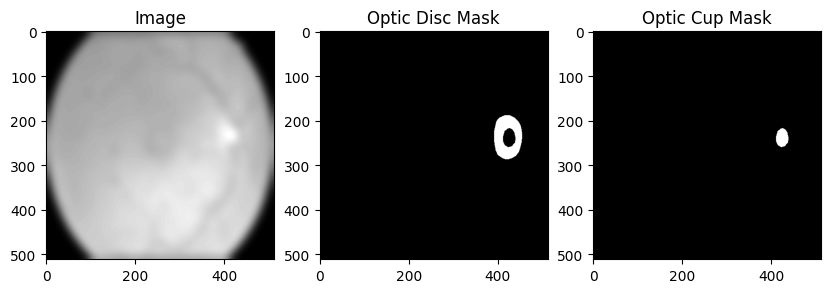

X_train: (560, 512, 512, 1), y_train: (560,)
X_val: (120, 512, 512, 1), y_val: (120,)
X_test: (120, 512, 512, 1), y_test: (120,)
Epoch 1/70
280/280 ━━━━━━━━━━━━━━━━━━━━ 97s 261ms/step - loss: 0.8237 - oc_output_accuracy: 0.9238 - oc_output_loss: 0.4127 - od_output_accuracy: 0.9840 - od_output_loss: 0.4111 - val_loss: 0.1315 - val_oc_output_accuracy: 0.9964 - val_oc_output_loss: 0.0313 - val_od_output_accuracy: 0.9831 - val_od_output_loss: 0.1003
Epoch 2/70
280/280 ━━━━━━━━━━━━━━━━━━━━ 62s 220ms/step - loss: 0.1232 - oc_output_accuracy: 0.9965 - oc_output_loss: 0.0292 - od_output_accuracy: 0.9840 - od_output_loss: 0.0940 - val_loss: 0.1214 - val_oc_output_accuracy: 0.9964 - val_oc_output_loss: 0.0279 - val_od_output_accuracy: 0.9831 - val_od_output_loss: 0.0935
Epoch 3/70
280/280 ━━━━━━━━━━━━━━━━━━━━ 62s 220ms/step - loss: 0.1145 - oc_output_accuracy: 0.9966 - oc_output_loss: 0.0258 - od_output_accuracy: 0.9840 - od_output_loss: 0.0887 - val_loss: 0.1154 - val_oc_output_accuracy: 0.9964

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.image import resize
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, LSTM
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, ResNet152, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from skimage import morphology
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import SMOTE


import matplotlib.pyplot as plt

IMAGES_FOLDER = "/kaggle/input/glaucoma-datasets/G1020/Images"
df = pd.read_csv("/kaggle/input/glaucoma-datasets/G1020/G1020.csv")
MASK_FOLDER = "/kaggle/input/glaucoma-datasets/G1020/Masks"

df = df.sample(n=200, random_state=42)
df = df.head(200)

def load_data(df, image_size=(512, 512)):
    images, labels, od_masks, oc_masks = [], [], [], []
    
    print(f"Total images in dataframe: {len(df)}")

    if not os.path.exists(IMAGES_FOLDER):
        print(f"Error: IMAGES_FOLDER not found: {IMAGES_FOLDER}")
    else:
        print(f"IMAGES_FOLDER found: {IMAGES_FOLDER}")

    missing_images = [img for img in df['imageID'] if not os.path.exists(os.path.join(IMAGES_FOLDER, img))]
    if missing_images:
        print(f"Missing images: {len(missing_images)} images not found.")

    def rotate_image(image, angle, is_mask=False):
        h, w = image.shape[:2]
        center = (w // 2, h // 2)
        interpolation = cv2.INTER_NEAREST if is_mask else cv2.INTER_LINEAR
        rot_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, rot_matrix, (w, h), flags=interpolation)
        return rotated.reshape(h, w, 1)

    
    for index, row in df.iterrows():
        img_name = row['imageID']
        label = row['binaryLabels']
        img_path = os.path.join(IMAGES_FOLDER, img_name)

        base_name = os.path.splitext(img_name)[0]  
        mask_name = f"{base_name}.png" 
        mask_path = os.path.join(MASK_FOLDER, mask_name)

        if os.path.exists(img_path) and os.path.exists(mask_path):
            image = cv2.imread(img_path, cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, image_size)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.GaussianBlur(image, (65, 65), 0)
            image = image.reshape(image_size[0], image_size[1], 1)

            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, image_size)

            optic_disc = np.where(mask == 1, 255, 0).astype(np.uint8).reshape(image_size[0], image_size[1], 1)
            optic_cup = np.where(mask == 2, 255, 0).astype(np.uint8).reshape(image_size[0], image_size[1], 1)

            images.append(image)
            labels.append(label)
            od_masks.append(optic_disc)
            oc_masks.append(optic_cup)

            for angle in [45, 90, 170]:
                rotated_img = rotate_image(image, angle, is_mask=False)
                rotated_od = rotate_image(optic_disc, angle, is_mask=True)
                rotated_oc = rotate_image(optic_cup, angle, is_mask=True)

                images.append(rotated_img)
                labels.append(label)
                od_masks.append(rotated_od)
                oc_masks.append(rotated_oc)

        else:
            print(f"Image not found: {img_path}")

    images = np.array(images) / 255.0
    labels = np.array(labels)
    od_masks = np.array(od_masks) / 255.0
    oc_masks = np.array(oc_masks) / 255.0

    print(f"Total images after augmentation: {len(images)}")
    print(f"Total labels: {len(labels)}")
    print(f"Total OD masks: {len(od_masks)}")
    print(f"Total OC masks: {len(oc_masks)}")

    idx = 0  
    plt.figure(figsize=(10,5))
    plt.subplot(131)
    plt.imshow(images[idx].squeeze(), cmap='gray')
    plt.title('Image')
    plt.subplot(132)
    plt.imshow(od_masks[idx].squeeze(), cmap='gray')
    plt.title('Optic Disc Mask')
    plt.subplot(133)
    plt.imshow(oc_masks[idx].squeeze(), cmap='gray')
    plt.title('Optic Cup Mask')
    plt.show()

    return images, labels, od_masks, oc_masks  
   
images, labels, od_masks, oc_masks = load_data(df)

X_train, X_temp, y_train, y_temp, od_train, od_temp, oc_train, oc_temp = train_test_split(
    images, labels, od_masks, oc_masks, test_size=0.3, random_state=42
)

X_val, X_test, y_val, y_test, od_val, od_test, oc_val, oc_test = train_test_split(
    X_temp, y_temp, od_temp, oc_temp, test_size=0.5, random_state=42
)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


def build_unet():
    inputs = layers.Input((512, 512, 1))

    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    c4 = Dropout(0.5)(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Dropout(0.5)(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    od_outputs = Conv2D(1, (1, 1), activation='sigmoid', name='od_output')(c9)
    oc_outputs = Conv2D(1, (1, 1), activation='sigmoid', name='oc_output')(c9)

    model = Model(inputs=inputs, outputs=[od_outputs, oc_outputs])
    return model

unet = build_unet()
unet.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.0004, momentum=0.95),
    loss='binary_crossentropy',
    metrics=[['accuracy'],['accuracy']]
)

unet.fit(X_train, [od_train, oc_train], epochs=70, batch_size=2, 
         validation_data=(X_val, [od_val, oc_val]))

od_pred, oc_pred = unet.predict(X_test)

print("Prediction complete!")



In [2]:
def calculate_cdr(disc_mask, cup_mask):
    disc_area = np.sum(disc_mask)
    cup_area = np.sum(cup_mask)
    disc_mask = (disc_mask > 0).astype(np.uint8)
    cup_mask = (cup_mask > 0).astype(np.uint8)


    return round((2 * cup_area) / disc_area, 4) if disc_area != 0 else 0

def extract_isnt_quadrants(disc_mask, cup_mask):
    disc_mask = disc_mask.squeeze()
    cup_mask = cup_mask.squeeze()

    disc_mask_rotated = np.rot90(disc_mask)
    cup_mask_rotated = np.rot90(cup_mask)

    nrr_mask = cv2.bitwise_xor(disc_mask_rotated, cup_mask_rotated)

    height, width = disc_mask.shape
    I = np.sum(nrr_mask[height//2:, :])
    S = np.sum(nrr_mask[:height//2, :])
    N = np.sum(nrr_mask[:, :width//2])
    T = np.sum(nrr_mask[:, width//2:])

    return round((1 + (I + S)) / (1 + (N + T)), 4) if (N + T) != 0 else 0

def extract_blood_vessels(fundus_image):
    if len(fundus_image.shape) == 2 or fundus_image.shape[2] == 1:
        green_channel = fundus_image[:, :, 0].astype(np.uint8)  # Use the only available channel
    else:
        green_channel = fundus_image[:, :, 1].astype(np.uint8) 
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(6,6))
    enhanced = clahe.apply(green_channel)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    bottom_hat = cv2.morphologyEx(enhanced, cv2.MORPH_BLACKHAT, kernel)

    threshold_value = max(10, 3.15 * np.std(bottom_hat))
    _, vessel_mask = cv2.threshold(bottom_hat, threshold_value, 255, cv2.THRESH_BINARY)

    height, width = vessel_mask.shape
    I = np.sum(vessel_mask[height//2:, :])
    S = np.sum(vessel_mask[:height//2, :])
    N = np.sum(vessel_mask[:, :width//2])
    T = np.sum(vessel_mask[:, width//2:])

    return round((1 + (I + S)) / (1 + (N + T)), 4) if (N + T) != 0 else 0

cdr_train = np.array([calculate_cdr(od, oc) for od, oc in zip(od_train, oc_train)])
isnt_train = np.array([extract_isnt_quadrants(od, oc) for od, oc in zip(od_train, oc_train)])
bvr_train = np.array([extract_blood_vessels(img) for img in X_train])

X_train_combined = np.hstack((cdr_train.reshape(-1,1), isnt_train.reshape(-1,1), bvr_train.reshape(-1,1)))

cdr_test = np.array([calculate_cdr(od, oc) for od, oc in zip(od_test, oc_test)])
isnt_test = np.array([extract_isnt_quadrants(od, oc) for od, oc in zip(od_test, oc_test)])
bvr_test = np.array([extract_blood_vessels(img) for img in X_test])

X_test_combined = np.hstack((cdr_test.reshape(-1,1), isnt_test.reshape(-1,1), bvr_test.reshape(-1,1)))

print(f"X_train_combined shape: {X_train_combined.shape}, y_train shape: {y_train.shape}")
print(f"X_test_combined shape: {X_test_combined.shape}, y_test shape: {y_test.shape}")

scaler = MinMaxScaler()
X_train_combined = scaler.fit_transform(X_train_combined)
X_test_combined = scaler.transform(X_test_combined)

smote = SMOTE(random_state=42)
X_train_combined, y_train = smote.fit_resample(X_train_combined, y_train)

svm = SVC(C=1000, gamma=10, kernel='rbf', probability=True)
svm.fit(X_train_combined, y_train)
svm_predictions = svm.predict(X_test_combined)

print(f"y_test shape: {y_test.shape}")
print(f"svm_predictions shape: {svm_predictions.shape}")

mlp = Sequential([
    Dense(1024, activation='relu', input_shape=(X_train_combined.shape[1],)),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),  
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])
mlp.compile(optimizer=Adam(learning_rate=0.005), loss=BinaryCrossentropy(), metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
mlp.fit(X_train_combined, y_train, epochs=200, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping])
mlp_predictions = (mlp.predict(X_test_combined).flatten() > 0.5).astype(int)


adaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=100, random_state = 10)
adaboost.fit(X_train_combined, y_train)
adaboost_predictions = adaboost.predict(X_test_combined)

knn = KNeighborsClassifier(n_neighbors=7, weights='distance', metric='manhattan')
knn.fit(X_train_combined, y_train)
knn_predictions = knn.predict(X_test_combined)

nb = GaussianNB()
nb.fit(X_train_combined, y_train)
nb_predictions = nb.predict(X_test_combined)



X_train_rnn = X_train_combined.reshape((X_train_combined.shape[0], X_train_combined.shape[1], 1))
X_test_rnn = X_test_combined.reshape((X_test_combined.shape[0], X_test_combined.shape[1], 1))

rnn_model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(X_train_combined.shape[1], 1)),
    Dropout(0.3),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

rnn_model.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy(), metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
rnn_model.fit(X_train_rnn, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping])
rnn_predictions = (rnn_model.predict(X_test_rnn).flatten() > 0.5).astype(int)


svm_accuracy = accuracy_score(y_test, svm_predictions)
mlp_accuracy = accuracy_score(y_test, mlp_predictions)
adaboost_accuracy = accuracy_score(y_test, adaboost_predictions)
knn_accuracy = accuracy_score(y_test, knn_predictions)
nb_accuracy = accuracy_score(y_test, nb_predictions)
rnn_accuracy = accuracy_score(y_test, rnn_predictions)
    
print(f"SVM Accuracy: {svm_accuracy}")
print(f"MLP Accuracy: {mlp_accuracy}")
print(f"AdaBoost Accuracy: {adaboost_accuracy}")
print(f"KNN Accuracy: {knn_accuracy}")
print(f"Naive Bayes Accuracy: {nb_accuracy}")
print(f"RNN Accuracy: {rnn_accuracy}")


X_train_combined shape: (560, 3), y_train shape: (560,)
X_test_combined shape: (120, 3), y_test shape: (120,)
y_test shape: (120,)
svm_predictions shape: (120,)
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.5782 - loss: 0.6836 - val_accuracy: 0.0000e+00 - val_loss: 0.8393
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6587 - loss: 0.6517 - val_accuracy: 0.0000e+00 - val_loss: 1.0123
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6145 - loss: 0.6676 - val_accuracy: 0.0000e+00 - val_loss: 0.9957
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6028 - loss: 0.6697 - val_accuracy: 0.0000e+00 - val_loss: 1.0850
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6201 - loss: 0.6522 - val_accuracy: 0.0000e+00 - val_loss: 0.9674
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6043 - loss: 0.6606 - val_accuracy: 0.0000e+00 - val_loss: 1.0055
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6432 - loss: 0.6364 - val_accuracy: 0.0000e+00 - val_loss: 0.9972
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6412 - loss: 0.6405 - val_ac

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.6362 - loss: 0.6881 - val_accuracy: 0.0000e+00 - val_loss: 0.8572
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6397 - loss: 0.6598 - val_accuracy: 0.0000e+00 - val_loss: 1.0292
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6316 - loss: 0.6603 - val_accuracy: 0.0000e+00 - val_loss: 0.8849
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6080 - loss: 0.6706 - val_accuracy: 0.0000e+00 - val_loss: 0.9232
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6291 - loss: 0.6604 - val_accuracy: 0.0000e+00 - val_loss: 0.9926
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6164 - loss: 0.6662 - val_accuracy: 0.0000e+00 - val_loss: 0.9671
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6240 - loss: 0.6607 - val_accuracy: 0.0000e+00 - val_loss: 0.9200
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6134 - loss: 0.66